In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


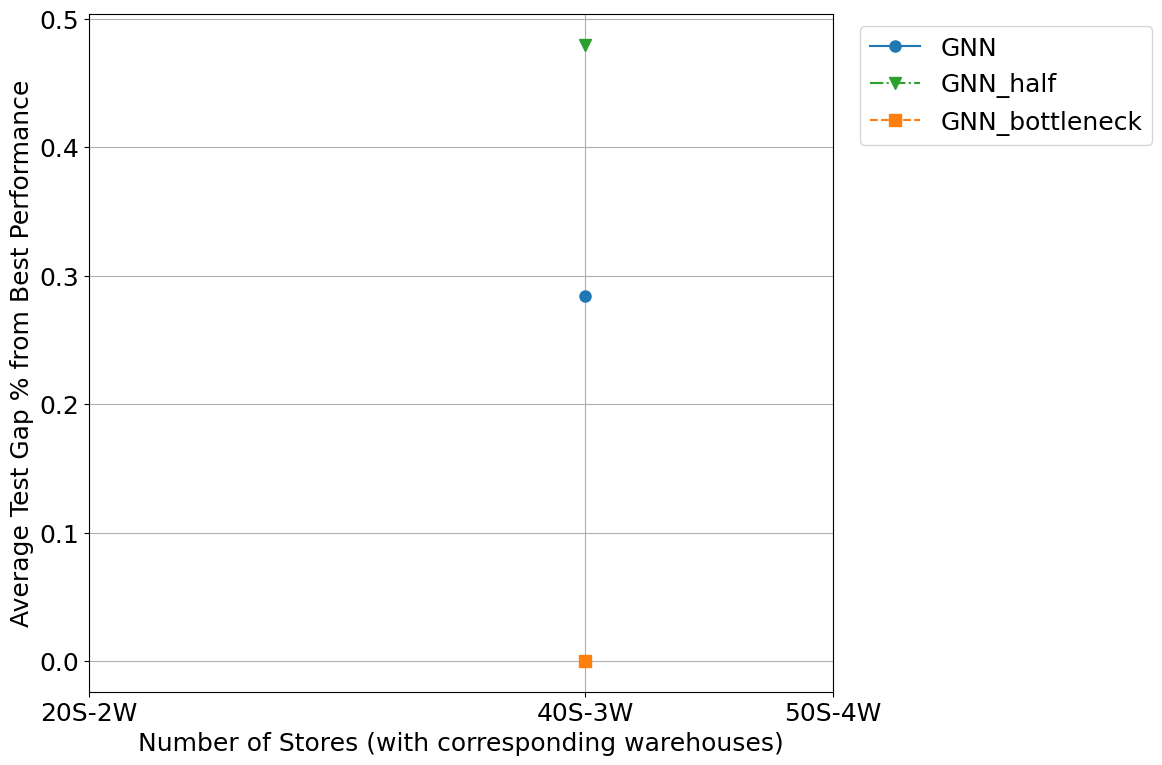

In [47]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_40_3_exp_varying_primitives"]#, "n_warehouse_20_2_exp_varying_primitives", "n_warehouse_50_4_exp"]
store_warehouse_pairs = {
    20: 2,
    40: 3,
    50: 4
}

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and markers for architectures
color_scheme = {
    "GNN": "#1f77b4",         # Blue
    "GNN_half": "#2ca02c",    # Green
    "GNN_bottleneck": "#ff7f0e", # Orange
    "vanilla_n_warehouses": "#d62728"  # Red
}

linestyle_scheme = {
    "GNN": "-",         # Solid
    "GNN_half": "-.",   # Dash-dot
    "GNN_bottleneck": "--", # Dashed
    "vanilla_n_warehouses": ":"  # Dotted
}

marker_scheme = {
    "GNN": "o",          # Circle
    "GNN_half": "v",     # Down triangle
    "GNN_bottleneck": "s", # Square
    "vanilla_n_warehouses": "^"  # Up triangle
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
    "GNN_half": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_half',
    "GNN_bottleneck": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_bottleneck',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define store sizes and sample size
store_sizes = [20, 40, 50]  # Corresponding to the testset names
sample_size = 8192

dfs = []

# Create dataframes for each architecture and store size
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        store_size = int(testset_name.split('_')[2])
        warehouse_size = store_warehouse_pairs[store_size]
        
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': [sample_size],
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['train_dev_sample_and_batch_size'] = sample_size
        df['n_warehouses'] = warehouse_size
        df['n_stores'] = store_size
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each store size
stats_by_arch_and_stores = {}
for store_size in store_sizes:
    store_data = df[df['n_stores'] == store_size].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
    
    for arch in store_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_stores:
            stats_by_arch_and_stores[key] = []
            
        arch_data = store_data[store_data['Architecture Class'] == arch]
        if not arch_data.empty:
            gaps = arch_data['Gap %'].to_numpy()
            mean_gap = np.mean(gaps)
            std_gap = np.std(gaps)
            ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
            stats_by_arch_and_stores[key].append({
                'n_stores': store_size,
                'mean_gap': mean_gap,
                'ci_lower': mean_gap - ci_95,
                'ci_upper': mean_gap + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(stores_array, mean_gap_array,
                marker=marker_scheme[arch],
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                markersize=8,
                label=arch)
        
        plt.fill_between(stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Stores (with corresponding warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Test Gap % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create single legend
plt.legend(bbox_to_anchor=(1.02, 1),
          loc='upper left',
          fontsize=FONTSIZE)

# Update x-axis ticks to show store-warehouse pairs
plt.xticks(store_sizes, [f'{s}S-{store_warehouse_pairs[s]}W' for s in store_sizes], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [48]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,GNN,8192,GNN,1,0.001,14.889184,14.476936,14.432196,7,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
1,1,GNN_half,8192,GNN_half,1,0.001,14.555502,14.503873,14.460388,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40
2,1,GNN_bottleneck,8192,GNN_bottleneck,1,0.010,14.538305,14.435970,14.391295,4,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3,40


In [44]:
pd.DataFrame([
    {
        'Architecture': arch,
        'Stores': stats['n_stores'],
        'Mean Gap %': stats['mean_gap'],
        'CI Lower': stats['ci_lower'],
        'CI Upper': stats['ci_upper']
    }
    for (arch), stats_list in stats_by_arch_and_stores.items()
    for stats in stats_list
]).pivot_table(
    index=['Architecture'],
    columns='Stores',
    values='Mean Gap %',
    aggfunc='first'
).round(2)

Stores,40
Architecture,
GNN,0.41
GNN_bottleneck,0.00
GNN_half,0.63
